In [31]:
import networkx as nx
import os
import sys
import urllib
from IPython.display import SVG

from networkx.algorithms.cluster import average_clustering
from sklearn.metrics import normalized_mutual_info_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sknetwork.clustering import Louvain, modularity
from sklearn.mixture import GaussianMixture
from sknetwork.embedding import Spectral, GSVD, LouvainEmbedding, PCA

from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph, svg_dendrogram
# from sknetwork.hierarchy import Paris
# from sknetwork.utils import KNNDense, CNNDense

In [145]:
url = 'https://s3.amazonaws.com/connectome-graphs/worm/c.elegans_neural.male_1.graphml'
#url = 'https://s3.amazonaws.com/connectome-graphs/fly/drosophila_medulla_1.graphml'
#url = "https://s3.amazonaws.com/connectome-graphs/cat/mixed.species_brain_1.graphml"
file = urllib.request.urlopen(url)

# Graph Operations

In [3]:
def get_graph(url):
    graph = nx.read_graphml(url)
    return graph

In [4]:
def normalize_graph(graph):
    new_graph = nx.Graph()
    for u, v in graph.edges():
        if new_graph.has_edge(u, v):
            new_graph[u][v]['weight'] += 1
        else:
            new_graph.add_edge(u, v, weight=1)
    return new_graph

In [5]:
def get_adj_matrix(graph):
    adj_matrix = nx.to_numpy_array(graph) # convert to adj matrix
    return adj_matrix

In [6]:
def get_sparse_adj_matrix(graph):
    adj_matrix = nx.convert_matrix.to_scipy_sparse_matrix(graph)
    return adj_matrix

# Embeddings

In [7]:
def make_embeddings(graph, embedding_type, embedding_param):
    if embedding_type == "gsvd":
        return get_gsvd_embeddings(graph, embedding_param)
    elif embedding_type == "spectral":
        return get_spectral_embeddings(graph, embedding_param)
    elif embedding_type == "louvain":
        return get_louvain_embeddings(graph, embedding_param)
    elif embedding_type == "pca":
        return get_pca_embeddings(graph, embedding_param)

In [8]:
def get_gsvd_embeddings(graph, components):
    adj_matrix = get_adj_matrix(graph)
    gsvd = GSVD(components)
    embedding = gsvd.fit_transform(adj_matrix)
    return embedding

In [9]:
def get_spectral_embeddings(graph, components):
    adj_matrix = get_adj_matrix(graph)
    spectral = Spectral(components)
    embedding = spectral.fit_transform(adj_matrix)
    return embedding

In [10]:
def get_louvain_embeddings(graph, resolution):
    # For some silly reason this one uses a different kind of matrix.
    adj_matrix = get_sparse_adj_matrix(graph)
    louvain = LouvainEmbedding(resolution)
    embedding = louvain.fit_transform(adj_matrix)
    return embedding

In [11]:
def get_pca_embeddings(graph, components):
    adj_matrix = get_adj_matrix(graph)
    pca = PCA(components)
    embedding = pca.fit_transform(adj_matrix)
    return embedding

# Clustering Methods - Obtain Labels

These ones take any type of embedding and let you specify the number of clusters.

In [12]:
# We can use any of the embedding methods and apply them here.
def k_means(embeddings, clusters):
    kmeans = KMeans(n_clusters=clusters)
    results = kmeans.fit_predict(embeddings)
    return results

In [13]:
# We can use any of the embedding methods and apply them here.
def gaussian_mixture(embeddings, clusters):
    gmm = GaussianMixture(n_components=clusters)
    results = gmm.fit_predict(embeddings)
    return results

These ones work a little differently.

In [14]:
# Unlike other methods, spectral clustering REQUIRES that you give it an adjacency matrix from which it will generate embeddings.
# Maybe this is not true. But documentation makes it look like you can?
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
def spectral_clustering(graph, clusters):
    adj_matrix = get_adj_matrix(graph)
    sc = SpectralClustering(clusters, affinity='precomputed', n_init=10, assign_labels='discretize')
    results = sc.fit_predict(adj_matrix)
    return results

In [158]:
# Unlike other methods, this automatically performs the Louvain algorithm and doesn't let you specify number of clusters.
def louvain_clustering(graph, res_param):
    adj_matrix = get_adj_matrix(graph)
    louvain = Louvain(res_param)
    results = louvain.fit_transform(adj_matrix)
    return results

# Metrics

In [16]:
def coefficient_cluster(graph):
    return average_clustering(graph)

In [17]:
def modularity_measure(graph, labels):
    real_adjacency = nx.convert_matrix.to_scipy_sparse_matrix(graph)
    return modularity(real_adjacency, labels)

In [18]:
def nmi_compare(graph1, graph2):
    return normalized_mutual_info_score(graph1, graph2)

# Visualization

In [19]:
# Most of the algorithms lead to labels, can make a visualization of the graph with labels with this function.
def make_visualization(graph, labels):
    adj_matrix = get_sparse_adj_matrix(graph)
    image = svg_graph(adj_matrix, labels=labels)
    return image

# Examples of Pipeline Usage

In [146]:
cat_graph = get_graph(file)

In [147]:
cat_graph = normalize_graph(cat_graph)

In [148]:
matrix = get_adj_matrix(cat_graph)

In [149]:
gsvd_embeddings = make_embeddings(cat_graph, "gsvd", 2)
spectral_embeddings = make_embeddings(cat_graph, "spectral",2)
louvain_embeddings = make_embeddings(cat_graph, "louvain", 2)
pca_embeddings = make_embeddings(cat_graph, "pca", 2)
embeddings = [gsvd_embeddings, spectral_embeddings, louvain_embeddings, pca_embeddings]

In [150]:
print("KMeans Modularities: ")
for i in range(4):
    embedding_method = embeddings[i]
    for j in range(2,10,2):
        # number of clusters is much higher for worm/fly than cat
        # can get rid of the plus 18 offset if doing cat
        k_means_labels = k_means(embedding_method, 18 + j) 
        print(modularity_measure(cat_graph, k_means_labels))

KMeans Modularities: 
0.10057095977249927
0.09451261348679686
0.08885950004992453
0.07286549964640683
0.16075333682564008
0.15149856605041367
0.13024081365226653
0.12428803781941156
0.2117002447818879
0.23189835039895657
0.21150482168852286
0.19223493736637381
0.10986471789003574
0.10879378193104612
0.10156589217317072
0.09648604370260923


In [153]:
print("Gaussian Modularities: ")
for i in range(4):
    embedding_method = embeddings[i]
    for j in range(2,10,2):
        gaussian_labels = gaussian_mixture(embedding_method, 18 + j)
        print(modularity_measure(cat_graph, gaussian_labels))

Gaussian Modularities for each embedding type & 18, 20, 22, 24 clusters: 
0.10267297398071044
0.09002374452022087
0.0822464993020869
0.07795848042596705
0.15137420590009043
0.1596198624048885
0.11635064498900463
0.12513214065941933
0.2144560329462754
0.21765780763576187
0.18380087190596048
0.19096775914464692
0.10709922768839579
0.110410003102476
0.09499346590830185
0.09771615451024224


In [156]:
print("Spectral Modularities")
or j in range(2,10,2):
    spectral_labels = spectral_clustering(cat_graph, 18 + j)
    print(modularity_measure(cat_graph, gaussian_labels))


Spectral Modularities
0.3151373245935982
0.3062317247632892
0.2872938600273262
0.2746388195841023


In [162]:
import numpy as np
print("Louvain Modularities")
res_param = 1.0
for i in range(0, 4):
    louvain_labels = louvain_clustering(cat_graph, res_param)
    res_param -= 0.1
    print(modularity_measure(cat_graph, louvain_labels))
    labels_unique, counts = np.unique(spectral_labels, return_counts=True)
    print(lenlabels_unique)

Louvain Modularities
0.37338300605746305
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
0.3699727527627414
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
0.36903994923914585
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
0.3613996844994761
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


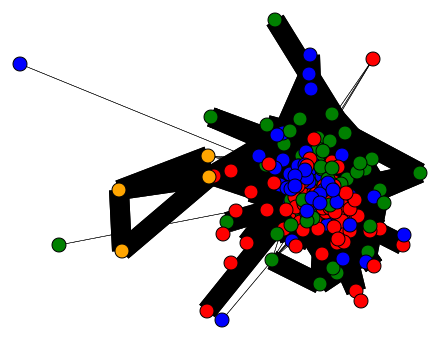

In [163]:
visualization = make_visualization(cat_graph, louvain_labels)
SVG(visualization)

In [ ]:
modularity_measure(cat_graph, k_means_labels)

# Related to Aggregate / Not Functionized Yet

In [137]:
labels_unique, counts = np.unique(labels, return_counts=True)
print(labels_unique, counts)

[0 1 2 3] [20 20 15 10]


In [37]:
real_adjacency = nx.convert_matrix.to_scipy_sparse_matrix(cat_graph)

In [171]:
image = svg_graph(real_adjacency, labels=labels)
#image = svg_graph(real_adjacency, embeddings, labels=labels)

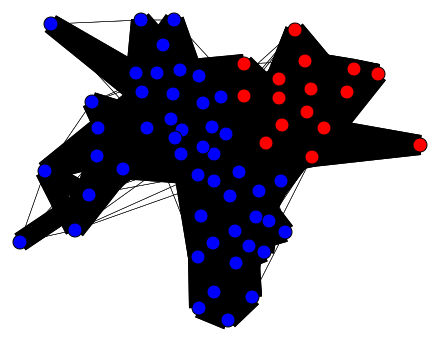

In [172]:
SVG(image)

In [173]:
f = open("SVG_test1.SVG", "a")
f.write(image)
f.close()

In [38]:
modularity(real_adjacency, labels)

0.2952187623571961

In [39]:
modularity_measure(cat_graph, labels)

0.2952187623571961

In [142]:
adjacency_aggregate = louvain.adjacency_

In [143]:
average = normalize(membership_matrix(labels).T)
position_aggregate = average.dot(embeddings)
labels_unique, counts = np.unique(labels, return_counts=True)

In [144]:
image = svg_graph(adjacency_aggregate, embeddings, counts, labels=labels_unique, display_node_weight=True, node_weights=counts)

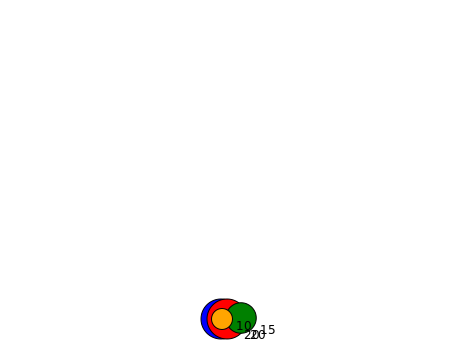

In [145]:
SVG(image)

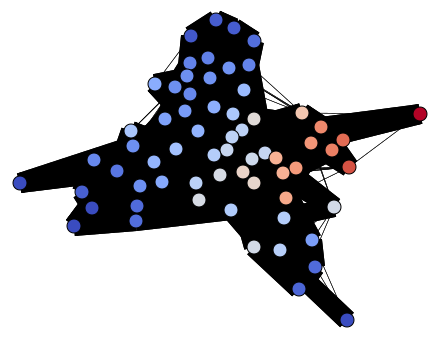

In [146]:
scores = louvain.membership_[:,1].toarray().ravel()
image = svg_graph(real_adjacency, scores=scores)
# image = svg_graph(real_adjacency, embeddings, scores=scores)
SVG(image)

In [147]:
from sknetwork.embedding import GSVD
from sknetwork.clustering import KMeans
kmeans = KMeans(n_clusters=2, embedding_method=GSVD(3))
labels = kmeans.fit_transform(real_adjacency)

In [148]:
unique_labels, counts = np.unique(labels, return_counts=True)
print(unique_labels, counts)

[0 1] [49 16]


In [149]:
image = svg_graph(real_adjacency, labels=labels)

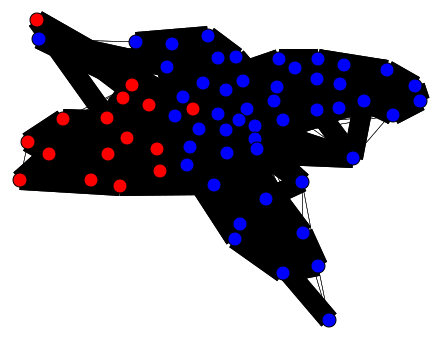

In [150]:
SVG(image)

In [151]:
modularity(real_adjacency, labels)

0.14707192745665865

In [152]:
adjacency_aggregate = kmeans.adjacency_
average = normalize(membership_matrix(labels).T)
position_aggregate = average.dot(embeddings)
labels_unique, counts = np.unique(labels, return_counts=True)

In [153]:
image = svg_graph(adjacency_aggregate, position_aggregate, counts, labels=labels_unique, display_node_weight=True, node_weights=counts)

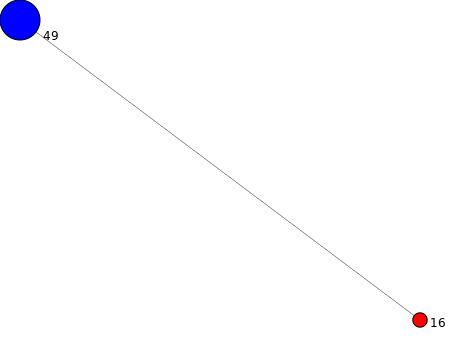

In [154]:
SVG(image)

In [155]:
scores = kmeans.membership_[:,1].toarray().ravel()
image = svg_graph(real_adjacency, scores=scores)
#image = svg_graph(real_adjacency, embeddings, scores=scores)

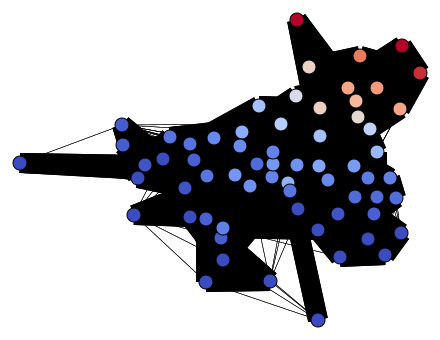

In [156]:
SVG(image)

# Nearest Neighbor Stuff - Not Sure Whether to Include

In [160]:
from sknetwork.utils import KNNDense, CNNDense
knn = KNNDense(n_neighbors=3, undirected=True)
adjacency = knn.fit_transform(matrix)

In [161]:
image = svg_graph(adjacency, labels=labels, display_edge_weight=False)

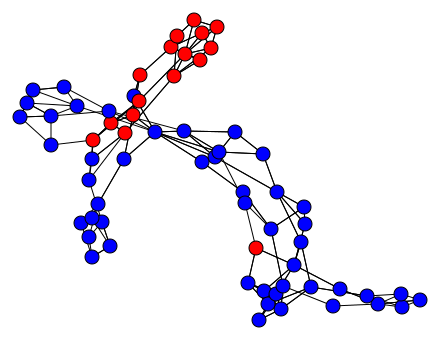

In [162]:
#regular nearest neighbors
SVG(image)


In [164]:
cnn = CNNDense(n_neighbors=2, undirected=True)
adjacency = cnn.fit_transform(matrix)
image = svg_graph(adjacency, labels=labels, display_edge_weight=False)


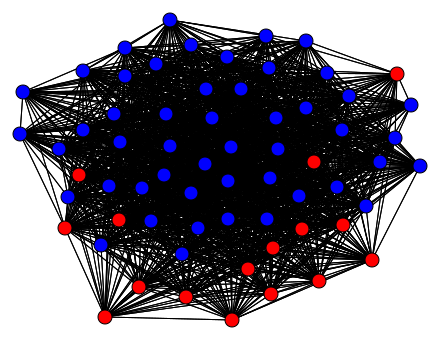

In [165]:
SVG(image)